# Neste notebook são geradas as simulações dos dados de entrada nas LSM, isso será usado posteriormente para encontrar a função de ativação utilizando regressão linear.


# Foram utilizados 3x experimentos como dados de entrada:
# 1-  50 Trials desenhando o quadrado perfeito na em cima de um caderno (superfície mole)
# 2-  + 25 Trials diretamente sobre o caderno em outro ângulo (caderno girado em 90º)
# 3-  +25 Trials usando o caderno com uma pequena inclinação no eixo X (aprox 1cm)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}

plt.rc('font', **font)

import numpy
import save_load_file as slf
import sys
from BEE import *

In [2]:
#simulation type
platform = "realBaxter"
trial_number = 0
total_trials = 100

#
# Controls if the results are saved to a file
#
save2file = True

#simulation type
#platform = "gazeboBaxter"
platform = "realBaxter"

##--data filenames--
input_filename = "XY_movement_square_+0.5cm"
#input_filename = "XY_movement_square_AJUSTABLE_0.5cm"
#input_filename = "XY_movement_square_HIGHTABLE3_free"

input_folder = "PIDs_DATA_FOR_THE_LSM"
data_folder = "PIDs_LSM"
sim_type = "with_PID_0.5cm"



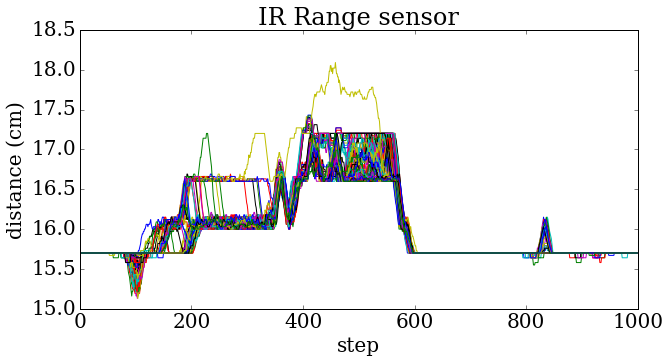

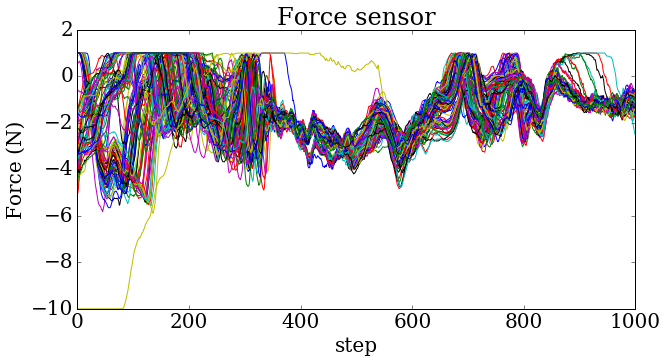

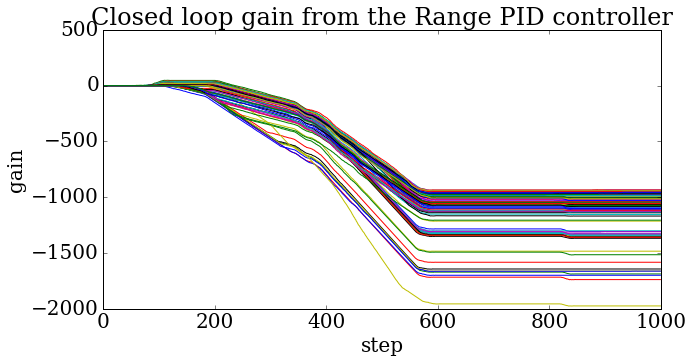

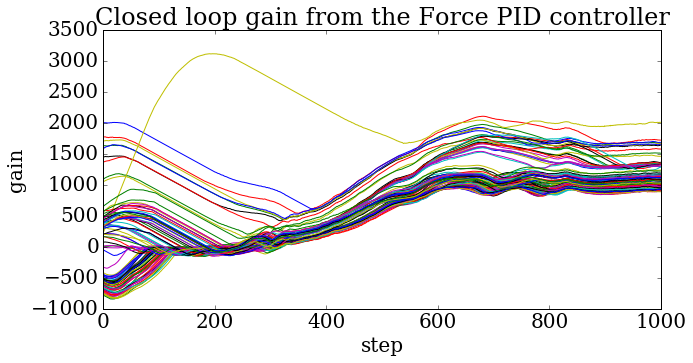

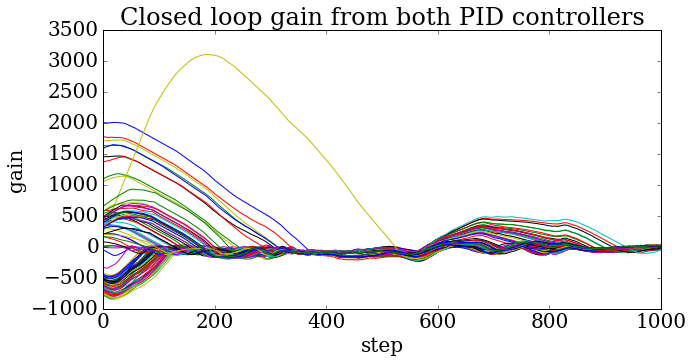

In [5]:
##Loads results to check how it went
##Poots both

ir_sensor=numpy.ndarray((total_trials,1000))
Zforce_hist=numpy.ndarray((total_trials,1000))
pidF_hist=numpy.ndarray((total_trials,1000))
pidR_hist=numpy.ndarray((total_trials,1000))

for trial_number in range(total_trials):
    #reads stuff
    ir_sensor[trial_number]=numpy.copy(numpy.load(input_folder+"/"+sim_type+"IRange_trial"+str(trial_number)+".npy"))
    Zforce_hist[trial_number]=numpy.copy(numpy.load(input_folder+"/"+sim_type+"Zforce_trial"+str(trial_number)+".npy"))
    pidF_hist[trial_number]=numpy.copy(numpy.load(input_folder+"/"+sim_type+"PID_Force_hist_trial"+str(trial_number)+".npy"))
    pidR_hist[trial_number]=numpy.copy(numpy.load(input_folder+"/"+sim_type+"PID_Range_hist_trial"+str(trial_number)+".npy"))
    #plots
    plt.figure(num=1,figsize=(10,5))
    plt.plot(ir_sensor[trial_number])
    
    plt.figure(num=2,figsize=(10,5))
    plt.plot(Zforce_hist[trial_number])
    
    plt.figure(num=3,figsize=(10,5))
    plt.plot(pidR_hist[trial_number])
    
    plt.figure(num=4,figsize=(10,5))
    plt.plot(pidF_hist[trial_number])
        
    plt.figure(num=5,figsize=(10,5))
    plt.plot(pidF_hist[trial_number]+pidR_hist[trial_number])
    
plt.figure(num=1,figsize=(10,5))
plt.title("IR Range sensor")
plt.ylabel("distance (cm)")
plt.xlabel("step")

plt.figure(num=2,figsize=(10,5))
plt.title("Force sensor")
plt.ylabel("Force (N)")
plt.xlabel("step")

plt.figure(num=3,figsize=(10,5))
plt.title("Closed loop gain from the Range PID controller")
plt.ylabel("gain")
plt.xlabel("step")

plt.figure(num=4,figsize=(10,5))
plt.title("Closed loop gain from the Force PID controller")
plt.ylabel("gain")
plt.xlabel("step")
    
plt.figure(num=5,figsize=(10,5))
plt.title("Closed loop gain from both PID controllers")
plt.ylabel("gain")
plt.xlabel("step")
plt.show()

In [6]:


# Total time spent during the movement (in seconds)
MT = 2.0

# Simulation time step (in seconds)
time_step = 2/1000.0
total_steps = int(MT/time_step)

# S0, S1, E1 and W1 are the Baxter's joint names
# vel_x and vel_y are the velocities from accelerometer data 
# Four joints + 2 velocities => Six input variables
Number_of_input_variables=2 # defines how the liquid is going to be divided to receive the inputs

#
# Number of neurons at each input layer (defines the INPUT resolution of the system)
#
# >>>>>>>>> It MUST be smaller or equal to (NofN/Number_of_input_variables) <<<<<<<<<<<
#
Ninput = 100


force_sensor_limits = numpy.array([-10. , 2.])
range_sensor_limits = numpy.array([15. , 18.])
force_sensor_setpoint = -2.0
range_sensor_setpoint = 15.7

In [7]:
input_array = numpy.array([ir_sensor[0],Zforce_hist[0]])

In [8]:
def generates_input_spikes_lsm(number_of_steps=total_steps, \
                               neurons_per_layer=Ninput, \
                               number_of_inputs=Number_of_input_variables, \
                               input_arr=numpy.copy(input_array)):
        
    
    # Creates the Ninput possible discrete values of angle for each joint
    # Because the normalisation all joints are ALWAYS between -1 and 1
    input_values_normalized=numpy.empty((neurons_per_layer,number_of_inputs))
    for ji in range(number_of_inputs):
        input_values_normalized[:,ji]=numpy.linspace(-1,1,neurons_per_layer)
    
    
    # Signal conditioning
    IR_range = range_sensor_limits[1]-range_sensor_limits[0]
    temp_IR=input_arr[0,:]-(range_sensor_limits[0]+IR_range/2)#-input_arr[0,0]
    temp_IR=temp_IR/float(IR_range/2)
    
    
    force_range = force_sensor_limits[1]-force_sensor_limits[0]
    temp_Force=input_arr[1,:]-(force_sensor_limits[0]+force_range/2)#-input_arr[1,0]
    temp_Force=temp_Force/float(force_range/2)

    
    input_normalized_idx = numpy.empty((number_of_steps,number_of_inputs),dtype=numpy.int)

    for i,jnt in zip(range(number_of_inputs),[temp_IR,temp_Force]):
        input_normalized_idx[:,i]=numpy.array([abs(input_values_normalized[:,i]-j).argmin() for j in jnt])
    
    
#     bias_vector =  input_arr[:,0]
#     print "Bias vector:", bias_vector
#     if save2file:
#         numpy.save(input_folder+"/"+normalized_input_folder+"/"+sim_type+"_bias_trial"+str(trial_number)+".npy",bias_vector)    
    
    normalized_IR = input_normalized_idx[:,0]
    normalized_Force = input_normalized_idx[:,1]
    
    return (normalized_IR,normalized_Force)

[]

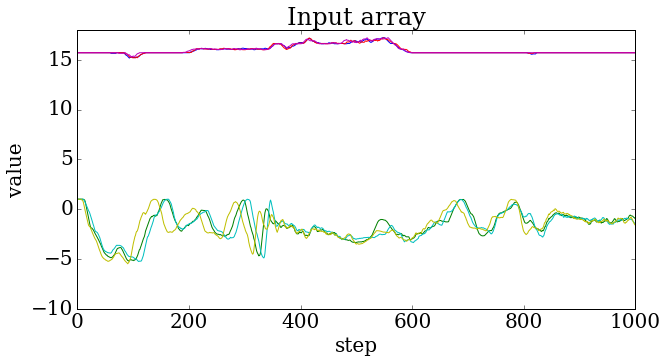

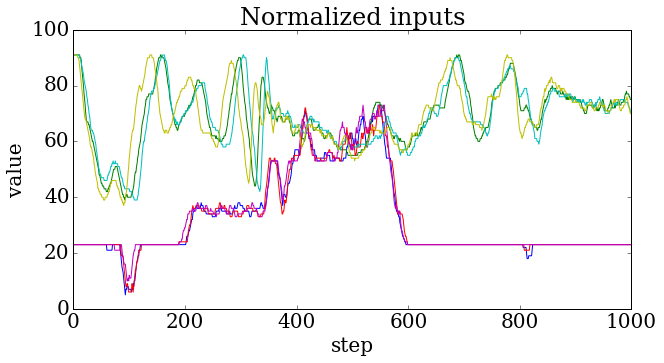

In [9]:
#just testing the function
for trial_number in (1,2,3):
    input_array = numpy.array([ir_sensor[trial_number],Zforce_hist[trial_number]])
    normalized_IR,normalized_Force = generates_input_spikes_lsm(input_arr=input_array)

    plt.figure(num=6,figsize=(10,5))
    plt.plot(input_array[0])
    plt.plot(input_array[1])
    plt.figure(num=7,figsize=(10,5))
    plt.plot(normalized_IR)
    plt.plot(normalized_Force)
    
plt.figure(num=6,figsize=(10,5))
plt.title("Input array")
plt.ylabel("value")
plt.xlabel("step")
plt.ylim(-10,18)

plt.figure(num=7,figsize=(10,5))
plt.title("Normalized inputs")
plt.ylabel("value")
plt.xlabel("step")
plt.ylim(0,Ninput)
plt.plot()

In [8]:
# 
# Defines how many liquids
# 
number_of_liquids = 5

liqseeds = []
for i in range(number_of_liquids):
    liqseeds.append(numpy.array(numpy.random.randint(0,10000,6),dtype=numpy.uint32))
#
# Comment the next line to generate NEW seeds
#
liqseeds=numpy.load(data_folder+"/"+"Contoller_liqseeds.npy")   

In [9]:
# Uncomment the next two lines to save the NEW seeds:
if save2file:
     numpy.save(data_folder+"/"+"Contoller_liqseeds.npy",liqseeds)

for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [4722 6714 8576 6334 4699 3401]
Liquid 1: [6414 8475 7022 1657 8307 5933]
Liquid 2: [5772 3395 5210 3482  288  759]
Liquid 3: [7898 1411 6211 2244  858 8653]
Liquid 4: [6489 9401 4603 5848 2598 5854]


# Simulations with different liquids start here!
## It needs to be repeated from lsm_i = 0 up to (number_of_liquids-1)

In [10]:
#
# Here the liquid index is defined
#
# REMEMBER: it goes from ZERO to number_of_liquids-1

lsm_i = 4


#
# Liquid's shape
#

# Liquid's shape
net_shape = numpy.array([8,5,5])

# Random seeds:
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
RANDOM_1=liqseeds[lsm_i][1]
RANDOM_2=liqseeds[lsm_i][2]
RANDOM_3=liqseeds[lsm_i][3]
#DEBUG!
# RANDOM_4=8337
# RANDOM_0=5751

RANDOM_input=liqseeds[lsm_i][5] # input gaussian noise

input_noise_std = 1 # Standard deviation of the input gaussian noise

# Neuron parameters
taum=0.03 # membrane time constant
cm=3e-08 # membrane capacitance
taue=0.003 # excitatory synapse time constant
taui=0.006 # inhibitory synapse time constant


# The "current_rand" noise source is the problematic one. Because it has a mean value different from
# zero, it generates a new liquid every run as the neuron models change according to the offset current "current_rand".

# Maass noisy sources
# membrane_rand=[0.0135, 0.015] # mean value 13.75E-3, uniform distribution, max value equal to threshold (15mV).
# current_rand=[14.975e-09, 15.025e-09] # mean value 15E-9, uniform distribution.
# noisy_current_rand=2e-10 # normal distribution, mean zero.


# Parameters paper Joshi/Maass
membrane_rand=[13.5E-3,14.9E-3] # mean value 13.7E-3, uniform distribution, max value below threshold (15mV).
current_rand=[13.5E-09, 14.5E-09] # mean value 14E-9, uniform distribution.
noisy_current_rand=1E-9 # normal distribution, mean zero.

factor=2*10.0

SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution


lbd_value = 1.2 

# Controls if the neurons are connected to each other (basically ignores the distance based connection probability)
disconnected = False

parameter_list=\
[[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
  [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
 [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
  [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]

# parameter_list = [] # Maass parameters change only the gains (nA): 1.2 (EE), 1.6 (EI), -3.0 (IE), -2.8 (II)
                    # instead of -47,-47,150,70

input_gain=105. # gain used for the input neurons
w_SD = 3.0 # input neurons standard deviation


#
# END OF THE SETUP - everything that should change between liquids is expressed above...
#


#
# This first initialization of the simulator is only used to generate the liquid structure's data
#

# Resets the simulator
BEE_free()

tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

input_noise_seed = RANDOM_input

if not BEE_initialized():
    initialize_sim(my_net_shape = net_shape, \
                   my_lbd_value = lbd_value, \
                   my_seeds=seeds, \
                   SpkLiq_step=time_step,\
                   SpkLiq_threads_N = 5,\
                   SpkLiq_vresets = SpkLiq_vresets_rand,\
                   SpkLiq_membrane_rand=membrane_rand,\
                   SpkLiq_current_rand=current_rand,\
                   SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                   SpkLiq_noisy_current_rand=noisy_current_rand)
    

if parameter_list!=[]:
    change_parameters(parameter_list)

if BEE_initialized() and (not BEE_connected()):
    generate_connections()

#
# Cancels the connections (if disconnected==True), but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)

if BEE_initialized() and (not BEE_connected()):
    process_connections()

NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats(stats=0)

# Normally the BEE simulator does NOT updates neurons that have no connections to other neurons.
# The neurons without connections are marked in a special array that can be read from the
# Python function output_connected(NofN).
# Every time the simulator goes through one step it checks if the neurons is marked as connected before
# updating its state variables.

# Disconnects all the neurons (nothing will generate spikes anymore)
# control_connected(numpy.zeros(NofN,dtype=numpy.int32))

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))


#
# Input converter
# 

# This information is used to define the neurons receiving inputs (excitatory neurons):
inhibitory_index_L = output_inh_indices(NoINHN)
inhibitory_index_L.shape

inhibitory_index_L=[] # input signals through all neurons (not only excitatory ones)

#
# Input pattern generation
# 

Number_of_neurons_lsm = NofN
Number_of_input_layers = Number_of_input_variables
Number_of_neurons_inputs = Ninput



# 
# 2D Gaussian generation
#

# DON'T FORGET I HAVE THE 3D and the flat version of the input code!!!!!!!!
# See: BEE_Simulator_ArmControl_v1_CONNECTION_PATTERN_VISUALIZATION_2D.ipynb

#
# Generates the connection pattern used. In the case below it's a gaussian 
# distributed one based on the connection weights.
#

inputs_indices = [] #inputs_indices[input_variable][ni]
inputs_weights = [] #inputs_weights[input_variable][ni]


def gaussian(lamb,n,nt):
    '''
    Generates a gaussian centered at 'n'
    '''
    return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

weight_func = gaussian


liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

# Goes through the liquid to generate the proper connections, 
# but dividing the liquid into the same number of input layers.
# Each input layer only connects to its own slice of the liquid.

centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

for inp in range(Number_of_input_layers): #goes through the input layers
    temp_i=[]
    temp_w=[]        
    for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                    range(Number_of_neurons_inputs)): #goes through the input neurons
        temp_i2 = []
        temp_w2 = []
        for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                        range(liquid_input_layer_size)):
            if j not in inhibitory_index_L:
                centre_position=centre_positions[ic]
                temp_weight=weight_func(w_SD,centre_position,ji)             
                if temp_weight>0: #guaranties only real spikes will be injected, saving cpu time
                    temp_w2.append(temp_weight) # in nA
                    temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron                                        
        temp_i.append(temp_i2)
        temp_w.append(temp_w2)
    inputs_indices.append(temp_i)
    inputs_weights.append(temp_w)

Simulator is not initialized!


# This is the readout training

In [87]:
def run_simulations_training(sim_num): 
    
    run_i, input_spikes, lsm_i = sim_num

    
    input_IR_sensor,input_force_sensor  = input_spikes
    
    #
    # Initializing the simulation...
    #
        
    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets <<<<<<<<
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<<
    # // RANDOM-3: Internal connections of the liquid <<<<<<<<
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3        

    liquid_soft_reset(seeds) # Resets the simulator

    number_of_steps = total_steps

    
    # Initialize the arrays with the simulated values
    # and saves the values for t=0s
    spikes = []
    ti=0
    
    # Runs the simulation going step-by-step
    # All the input variables are always used (no delay)
    for IR_sensor,force_sensor in zip(input_IR_sensor,input_force_sensor):
        
        input_spikes = [IR_sensor,force_sensor]

        # Generates the input spikes (and weights) based on the connection pattern defined.
        # The '[:,1]' is used to pass the post-synaptic (second column) neuron index
        exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) for input_variable,ni \
                                        in zip(range(len(input_spikes)),input_spikes)])
        inh_inputs = []
        exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) for input_variable,ni \
                                          in zip(range(len(input_spikes)),input_spikes)])
        inh_weights = []

        # Here the simulator is receiving the input spikes:
        updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs),0)

        # Appends to the output
        spikes.append([ti,reads_spikes(NofN)])
        ti+=time_step        
    
    if save2file:
        slf.save_to_file_gz(spikes,"./"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle")

In [88]:
%%time
total_trials = 100

for trial_number in range(total_trials):    
    
    input_array = numpy.array([ir_sensor[trial_number],Zforce_hist[trial_number]])
    normalized_IR,normalized_Force = generates_input_spikes_lsm(input_arr=input_array)
    input_spikes = (normalized_IR,normalized_Force)
    
    # Uncomment the next lines to be able to run the simulations!
    sim_num  = [ trial_number , input_spikes , lsm_i ]
    run_simulations_training(sim_num)
    
    

CPU times: user 41.5 s, sys: 15.8 s, total: 57.3 s
Wall time: 51.3 s


./PIDs_LSM/sensors_LSM_4_0.gzpickle
Total number of spikes: 43354
Total Number of Spikes Generated:43354
Total Number of Neurons:200000
Figure Spike Density(%):21.677000


<IPython.core.display.Javascript object>


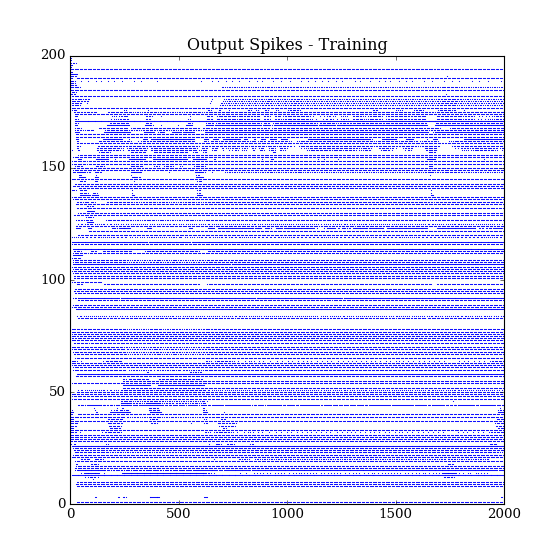

./PIDs_LSM/sensors_LSM_4_55.gzpickle
Total number of spikes: 45941
Total Number of Spikes Generated:45941
Total Number of Neurons:200000
Figure Spike Density(%):22.970500


<IPython.core.display.Javascript object>


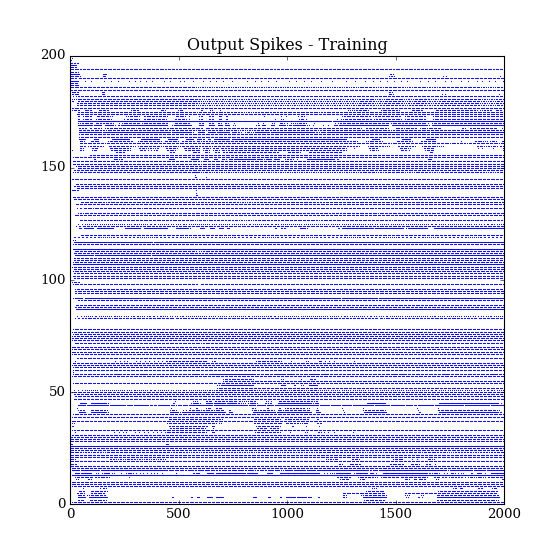

./PIDs_LSM/sensors_LSM_4_80.gzpickle
Total number of spikes: 44833
Total Number of Spikes Generated:44833
Total Number of Neurons:200000
Figure Spike Density(%):22.416500


<IPython.core.display.Javascript object>


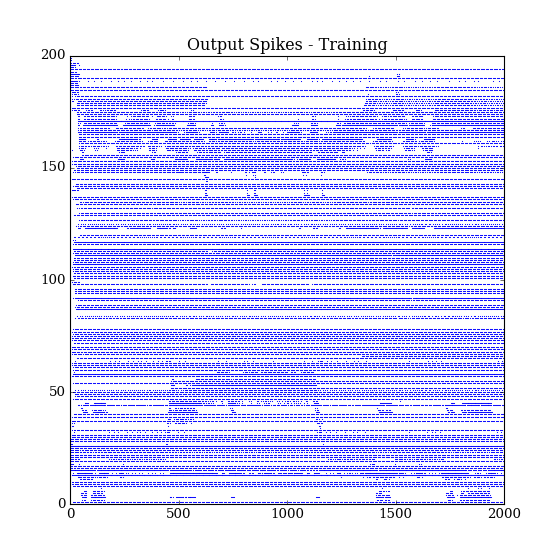

In [89]:
for run_i in (0,55,80):
    print "./"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle"
    spikes_sim=slf.load_from_file_gz("./"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle")
    spikes = [i[1] for i in spikes_sim]
    t = [i[0] for i in spikes_sim]

    total_spikes = len(numpy.concatenate(spikes))
    print "Total number of spikes:",total_spikes

    number_of_steps = total_steps
    print "Total Number of Spikes Generated:%d\nTotal Number of Neurons:%d\nFigure Spike Density(%%):%f" \
    %(total_spikes,NofN*len(spikes),100*total_spikes/float(NofN*len(spikes)))
    x_plot = numpy.array([t[ti] for i,ti in zip(spikes,xrange(len(spikes))) for j in i])
    y_plot = [j for i,ti in zip(spikes,xrange(len(spikes))) for j in i]

    plt.figure(figsize=(7,7))
    plt.plot(x_plot*1000,y_plot,'.', markersize=1)#, markevery=100)
    # plt.plot(y_plot,'.', markersize=1)#, markevery=100)
    # plt.plot(x_plot*1000,y_plot,'.')
    plt.xlim(t[0]*1000-1,t[-1]*1000+2)
    plt.ylim(0,NofN)
    plt.title("Output Spikes - Training")
    plt.show()

# SIMULATION TO TEST THE READ OUT 
# COEFICIENTS MUST BE FOUND FIRST USING THE LINEAR REGRESSION

In [35]:
# Here it's selected WHICH liquid to use:
# (remember, there are multiple liquids => number_of_liquids)
# lsm_i goes from 0 to (number_of_liquids-1)
lsm_i = 4

liqseeds=numpy.load(data_folder+"/"+"Contoller_liqseeds.npy")   
RANDOM_0,RANDOM_1,RANDOM_2,RANDOM_3,RANDOM_4,_ = liqseeds[lsm_i] # the "_" ignores the input noise seed
RANDOM_1,RANDOM_2,RANDOM_3

(9401, 4603, 5848)

In [36]:
filename = "./"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+".gzpickle"
[c_sensors,r_sensors] = slf.load_from_file(filename)

In [37]:
# Resets the simulator
BEE_free()

# Initializes the simulator
tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets <<<<<<<
# // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<
# // RANDOM-3: Internal connections of the liquid <<<<<<<
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

#DEBUG!
# seeds[4] = RANDOM_4
# seeds[0] = RANDOM_0


print "Initializing the simulator..."
if not BEE_initialized():
    %time initialize_sim(my_net_shape = net_shape, \
                         my_lbd_value = lbd_value, \
                         my_seeds=seeds, \
                         SpkLiq_step=tstp,\
                         SpkLiq_threads_N = 5,\
                         SpkLiq_vresets = SpkLiq_vresets_rand,\
                         SpkLiq_membrane_rand=membrane_rand,\
                         SpkLiq_current_rand=current_rand,\
                         SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                         SpkLiq_noisy_current_rand=noisy_current_rand)

if parameter_list!=[]:
    change_parameters(parameter_list)

generate_connections()

#
# Cancels the connections, but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)


process_connections()

print "Verifies..."
NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats()

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))

Initializing the simulator...
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 857 µs
Verifies...
('Total number of neurons:', 200)
('Number of inhibitory neurons:', 40)
('Number of excitatory neurons:', 160)
('Number of inhibitory connections:', 72)
('Number of excitatory connections:', 291)


In [38]:
def run_test(using_spikes = 0, membrane_time_constant = 30E-3):
#     using_spikes = 0 #Uses only the spikes without the membrane low-pass filtering
#     membrane_time_constant = 30E-3 #time constant used with the membrane low-pass filter

    # Total time spent during the movement (in seconds)
    MT = 2.0
    # Simulation time step (in seconds)
    time_step = 2/1000.0

    total_steps = int(MT/time_step)

    number_of_steps = total_steps

    # Initializing the simulation...
    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons
    # // RANDOM-3: Internal connections of the liquid
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3

    #DEBUG!
#     seeds[4] = RANDOM_4
#     seeds[0] = RANDOM_0
    

    liquid_soft_reset(seeds) # Resets the simulator
    

    # Initialize the arrays with the simulated values
    # and saves the values for t=0s
    t = []
    spikes = []
    inputs = []
    ti=0
#     t.append(ti)
#     spikes.append(reads_spikes(NofN))


    import membrane_lowpass_md
    reload(sys.modules['membrane_lowpass_md']) # Makes sure the interpreter is going to reload the module
    membrane_lowpass = membrane_lowpass_md.membrane_lowpass

    # In this system the initial position is given and the SNN should generate the next ones.
    # These are the values for step=0
    normalized_IR=normalized_inputs[0]
    normalized_Force=normalized_inputs[1]
    
    
    m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane

    controller_out = []
    OutputSpks_save = []
    OutputSpks_Filtered_save = []

    
    # Runs the simulation going step-by-step
    for step_i in range(number_of_steps):

                
        input_spikes = [normalized_IR[step_i],normalized_Force[step_i]]
        
        inputs.append(input_spikes)
        
        exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) \
                                        for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_inputs = []
        exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) \
                                          for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_weights = []

        # Here the simulator is receiving the input spikes (and returning the output ones):
        # r, current_t, received_spikes, OutputSpks, t = s.run_step(input_spikes) # Sends the spikes and reads the output
        updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs), 0)

        
        # Appends to the output
        t.append(ti)
        spikes.append(reads_spikes(NofN))
        ti+=tstp
        
        OutputSpks = spikes[-1]

        if using_spikes:
            Output = numpy.zeros(NofN); Output[OutputSpks]=1 # Using the output of the liquid directly
        else:
            m_v.process_spikes(OutputSpks,ti) # Send the spikes to the membrane filter
            OutputSpks_Filtered = m_v.check_values(ti) # Reads the values of the membranes
            #OutputSpks_Filtered_save.append(OutputSpks_Filtered)        
            Output = OutputSpks_Filtered # Using the low-pass (membrane) filtered version of the liquid's output

        controller=(Output.dot(c_sensors)+r_sensors) # Calculates the joint angles from the membrane filtered values
        controller_out.append(controller)
    return inputs, t, spikes, controller_out

In [39]:
%%time

number_of_trials=5

t_batch=[]
spikes_batch=[]
controller_batch=[]
inputs_batch = []
PID_outputs = []
for trial_number in (1,15,30,60,70,78,85):

    input_array = numpy.array([ir_sensor[trial_number],Zforce_hist[trial_number]])
    normalized_IR,normalized_Force = generates_input_spikes_lsm(input_arr=input_array)
    normalized_inputs = normalized_IR,normalized_Force
    
    inputs, t, spikes, controller_out=run_test()
    t_batch.append(t)
    PID_outputs.append(pidF_hist[trial_number]+pidR_hist[trial_number])
    spikes_batch.append(spikes)
    controller_batch.append(controller_out)
    inputs_batch.append(inputs)

CPU times: user 1.73 s, sys: 3.98 s, total: 5.71 s
Wall time: 5.13 s


In [40]:
len(inputs_batch)

7

<IPython.core.display.Javascript object>


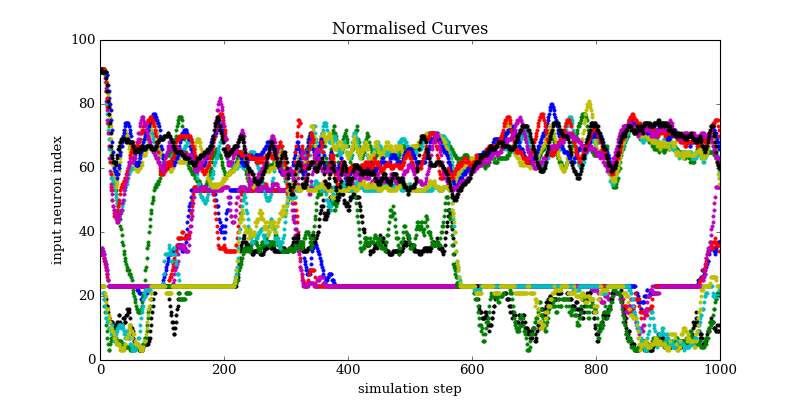

In [41]:
plt.figure(figsize=(10,5))
for trial_number in range(len(inputs_batch)):
    v = numpy.asarray(inputs_batch[trial_number]).transpose()

    
    for vi,ji in zip(v,['IR','Force']):
        plt.plot(vi,'.', label=ji)
plt.title("Normalised Curves")
plt.ylabel("input neuron index")
plt.xlabel("simulation step")
plt.ylim(0,Ninput)
plt.show()

<IPython.core.display.Javascript object>


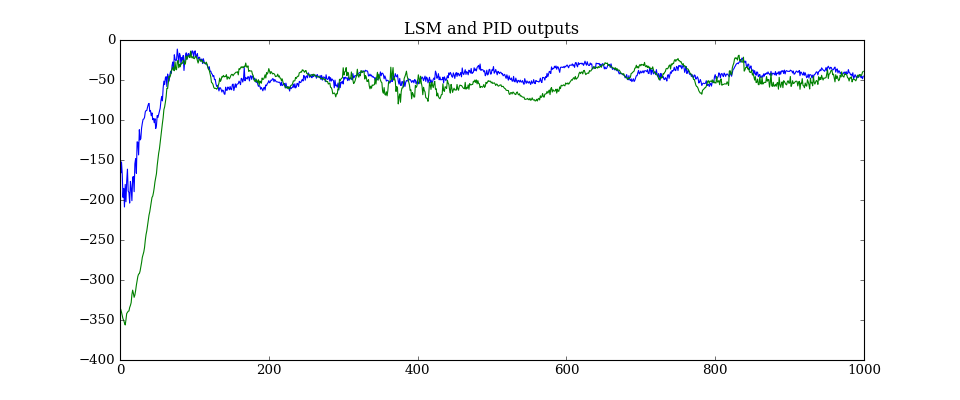

<IPython.core.display.Javascript object>


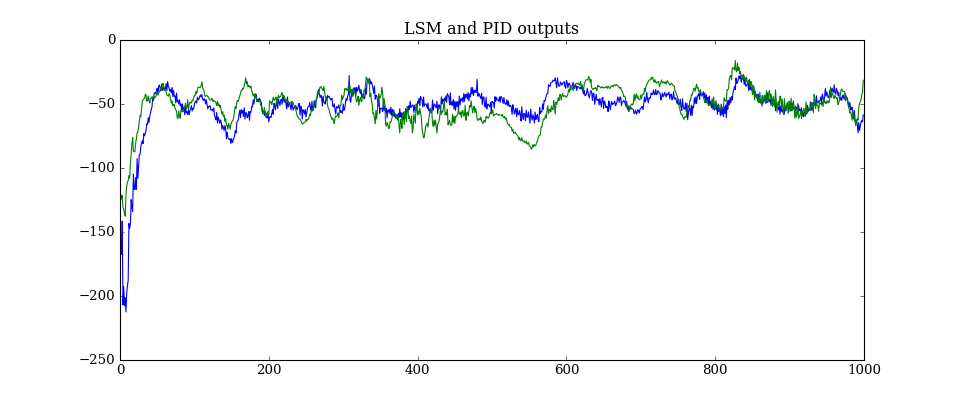

<IPython.core.display.Javascript object>


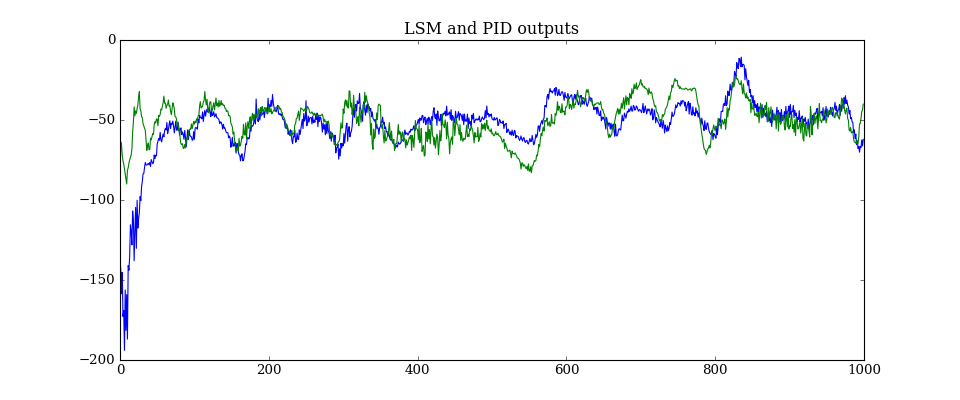

<IPython.core.display.Javascript object>


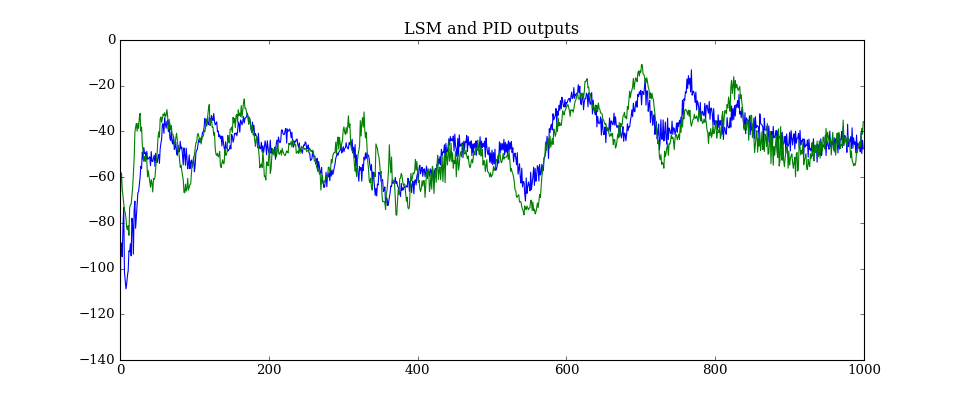

<IPython.core.display.Javascript object>


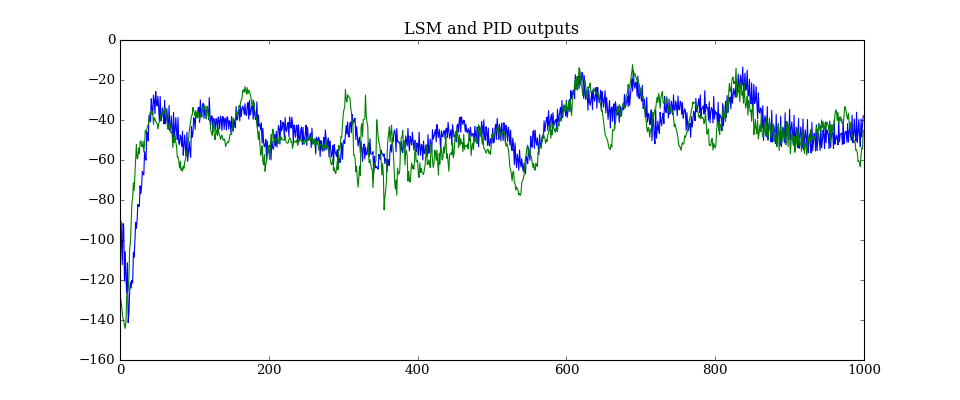

<IPython.core.display.Javascript object>


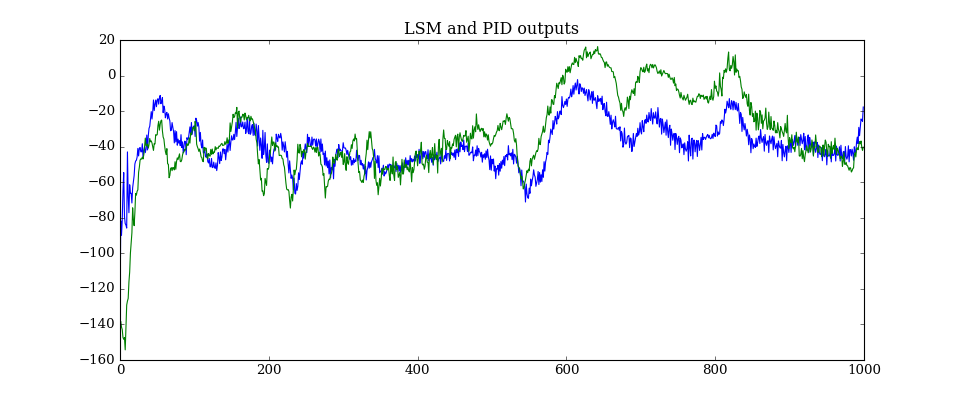

<IPython.core.display.Javascript object>


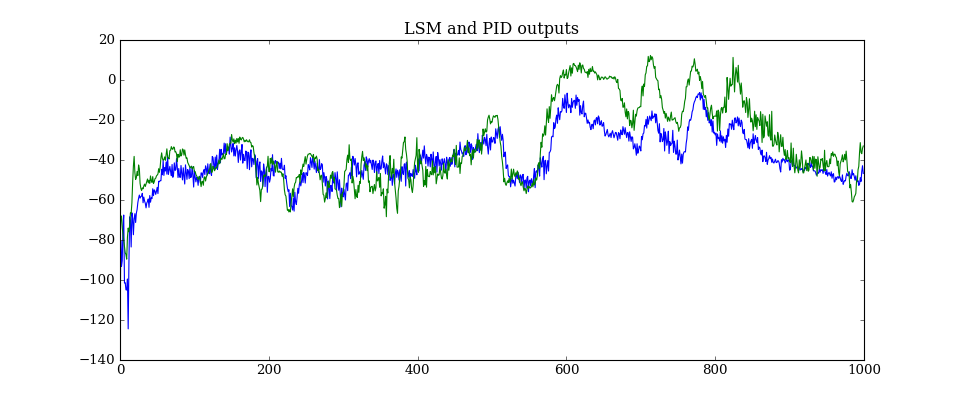

In [42]:


for trial_number in range(len(inputs_batch)):
    plt.figure(figsize =(12,5))
    plt.plot((controller_batch[trial_number]),label="Calculated")
    plt.plot(PID_outputs[trial_number],label="Original")
    plt.title("LSM and PID outputs")
    plt.show()

# RESULTS:

Liquid 0: [4722 6714 8576 6334 4699 3401] -- Erro enorme (rede não possui dinâmica suficiente?)

Liquid 1: [6414 8475 7022 1657 8307 5933] -- Tá legal!

Liquid 2: [5772 3395 5210 3482  288  759] -- Bem legal!

Liquid 3: [7898 1411 6211 2244  858 8653] -- Legal!

Liquid 4: [6489 9401 4603 5848 2598 5854] -- Tá boa!

# NO BRASIL: FAZER ANALISE DE ERRO E TAL!!!!!